In [48]:
from src.utils.plot import *
from src.utils.mesh import *

import json
import os
import cv2


%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook

from matplotlib import pyplot as plt
from pytorch3d.io import load_obj

from pytorch3d.renderer import (
    OpenGLPerspectiveCameras, RasterizationSettings,
    MeshRenderer, MeshRasterizer, SoftSilhouetteShader,
    look_at_view_transform, SoftPhongShader
)

from pytorch3d.structures import join_meshes_as_batch

IMAGE_PATH = '/home/xingrui/vqa/super-clevr-gen/output/ver_mask_new/images'
# PRED_FILE = '/home/xingrui/vqa/superclevr-NSVQA/data/parts-nemo/reason/scene_pred-nemo.json'
# PRED_FILE = '/home/xingrui/vqa/FaseRCNN3d_PNSVQA/data/fastRCNN3D/reason/scene_pred-fastrcnn3d.json'
PRED_FILE = '/home/xingrui/vqa/FaseRCNN3d_PNSVQA/faster_rcnn_6d/fastrcnn_detection.json'




In [17]:
def load_obj_file(file_path):
    verts, faces, aux = load_obj(file_path)
    x3d = verts.numpy()
    xface = faces.verts_idx.numpy()
    x3d = x3d[:, [0, 2, 1]]
    x3d[:, 1] = -x3d[:, 1]
    
    return x3d, xface

In [18]:
def plot_mesh_obj(img, mesh_path, azimuth, elevation, theta, distance, principal, down_sample_rate=8, fuse=True, size=1.0, color=[1, 1, 1]):
    h, w, c = img.shape
    render_image_size = max(h, w)
    crop_size = (h, w)

    # cameras = OpenGLPerspectiveCameras(device='cuda:0', fov=12.0)
    cameras = PerspectiveCameras(focal_length=12.0, device='cuda:0')
    raster_settings = RasterizationSettings(
        image_size=render_image_size,
        blur_radius=0.0,
        faces_per_pixel=1,
        bin_size=0
    )
    raster_settings1 = RasterizationSettings(
        image_size=render_image_size // down_sample_rate,
        blur_radius=0.0,
        faces_per_pixel=1,
        bin_size=0
    )
    raster_settings2 = RasterizationSettings(
        image_size=(crop_size),
        blur_radius=0.0,
        faces_per_pixel=1,
        bin_size=0
    )
    rasterizer = MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    )
    lights = PointLights(device='cuda:0', location=((2.0, 2.0, -2.0),))
    
    phong_renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=cameras,
            raster_settings=raster_settings
        ),
        shader=HardPhongShader(device='cuda:0', lights=lights, cameras=cameras)
    )

    x3d, xface = load_obj_file(mesh_path)

    x3d = x3d * size
    verts = torch.from_numpy(x3d).to('cuda:0')
    verts = pre_process_mesh_pascal(verts)
    faces = torch.from_numpy(xface).to('cuda:0')
    # verts_rgb = torch.ones_like(verts)[None]
    verts_rgb = torch.ones_like(verts)[None] * torch.Tensor(color).view(1, 1, 3).to(verts.device)
    textures = Textures(verts_rgb.to('cuda:0'))
    # meshes = Meshes(verts=[verts], faces=[faces])
    meshes = Meshes(verts=[verts], faces=[faces], textures=textures)

    C = camera_position_from_spherical_angles(distance, elevation, azimuth, degrees=False, device='cuda:0')
    R, T = campos_to_R_T(C, theta, device='cuda:0')
    image = phong_renderer(meshes_world=meshes.clone(), R=R, T=T)
    image = image[:, ..., :3]
    box_ = bbt.box_by_shape(crop_size, (render_image_size // 2,) * 2)
    bbox = box_.bbox

    image = image[:, bbox[0][0]:bbox[0][1], bbox[1][0]:bbox[1][1], :]
    image = torch.squeeze(image).detach().cpu().numpy()
    image = np.array((image / image.max()) * 255).astype(np.uint8)

    cx, cy = principal
    dx = int(-cx + w/2)
    dy = int(-cy + h/2)

    image_pad = np.pad(image, ((abs(dy), abs(dy)), (abs(dx), abs(dx)), (0, 0)), mode='edge')
    image = image_pad[dy+abs(dy):dy+abs(dy)+image.shape[0], dx+abs(dx):dx+abs(dx)+image.shape[1]]

    
    if fuse:
        a = 0.8
        mask = (image.sum(2) != 765)[:, :, np.newaxis]
        img = img * (1 - a * mask) + image * a * mask
        return np.clip(np.rint(img), 0, 255).astype(np.uint8), image, rasterizer(meshes)
    else:
        return image

    if fuse:
        get_image = alpha_merge_imgs(img, image)
        # get_image = np.concatenate([raw_img, image], axis=1)
        return get_image
    else:
        return image

In [19]:
def verts_proj(verts, azimuth, elevation, theta, distance, principal=None, M=3000, device='cpu'):
    C = camera_position_from_spherical_angles(distance, elevation, azimuth, degrees=False, device=device)
    R, T = campos_to_R_T(C, theta, device=device)

    return verts_proj_matrix(verts, R, T, principal=principal, M=M)

In [49]:
with open(PRED_FILE) as f:
    nemo_pred = json.load(f)

In [53]:
image_id = '31810'
pred = nemo_pred[image_id]
img = cv2.imread(os.path.join(IMAGE_PATH, f"superCLEVR_new_{int(image_id):06d}.png"))
img = img[:, :, ::-1]


In [27]:
# mesh_path = '/home/xingrui/vqa/nemo_superclevr_copy/CAD_cate/car/01.off'
mesh_path = '/home/xingrui/data/CGPart/models/car/bad0a52f07afc2319ed410a010efa019/models/model_normalized.obj'
mesh_path = '/home/xingrui/data/CGPart/models/car/bad0a52f07afc2319ed410a010efa019/models/model_normalized.obj'
part_mesh_path = '/home/xingrui/data/CGPart/partobjs/car/bad0a52f07afc2319ed410a010efa019/front_right_wheel.obj'





In [54]:
object_id = 0

# {"azimuth": 1.6414963006973267, "elevation": 1.008655071258545, "theta": 0.0, "distance": 36.39065170288086, "px": 18.00009250640869, "py": -2.993289828300476, "principal": [464.00074005126953, 216.0536813735962]

# plt.imshow(img)
outputs=[]
for object_id in range(len(pred)):
    output, segmentation_mask, depth = plot_mesh_obj(img, mesh_path, pred[object_id]['azimuth'],pred[object_id]['elevation'], \
            pred[object_id]['theta'],pred[object_id]['distance'],pred[object_id]['principal'])
    outputs.append(output)
# output[segmentation_mask[:, :, 0], :] = 255
# plt.imshow(output)
# plt.imshow(segmentation_mask)

In [18]:
len(outputs)

8

In [51]:
# plt.imshow(img)
img = cv2.imread(os.path.join(IMAGE_PATH, f"superCLEVR_new_{int(image_id):06d}.png"))
output = cv2.imread(os.path.join(IMAGE_PATH, f"superCLEVR_new_{int(image_id):06d}.png"))
output = output[:, :, ::-1]
img = img[:, :, ::-1]


for c_name in [ 'car','aeroplane','bus']:
    img_name = f"/home/xingrui/vqa/nemo_superclevr_copy/output/json/0511/{c_name}_{c_name}/superCLEVR_new_031809/pred.png"
    o = cv2.imread(img_name)
    o = o[:, :, ::-1]

    same = o!=img
    output[same] = o[same]
    # output += o-img

                      

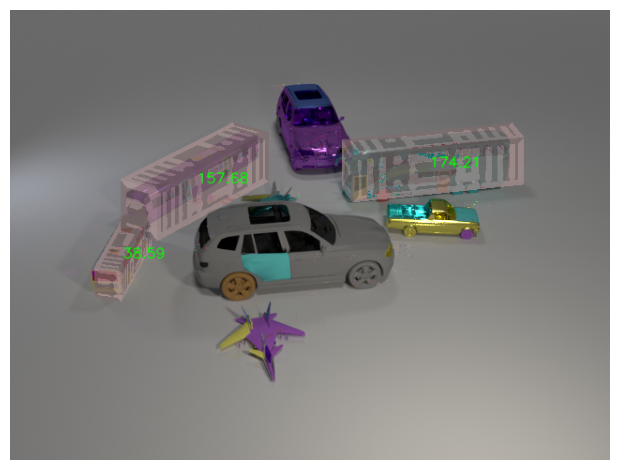

In [52]:
plt.imshow(output)
plt.axis('off')
# plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
plt.tight_layout()
# plt.show()
plt.savefig('debug.png')

In [55]:

import json
import os
import random
import pdb
import sys
import re


part_name_match = {}
def load_properties_json(properties_json, label_dir):
    with open(properties_json, 'r') as f:
        properties = json.load(f)
    # remove the car addi from the loaded json file
    properties['shapes'].pop('addi')
    properties['info_material'].pop('addi')
    
    # properties['shapes'].pop('wagon') #TODO
    # properties['info_material'].pop('wagon')
    color_name_to_rgba = {}
    for name, rgb in properties['colors'].items():
        rgba = [float(c) / 255.0 for c in rgb] + [1.0]
        color_name_to_rgba[name] = rgba
    
    size_mapping = list(properties['sizes'].items())
    obj_info = {}
    obj_info['info_pth'] = properties['shapes']
    obj_info['info_z'] = properties['info_z']
    obj_info['info_box'] = properties['info_box']
    obj_info['info_material'] = {k:v.split(',') for k,v in properties['info_material'].items()}
    hier_map = {v:k for k,vs in properties['info_hier'].items() for v in vs }
    obj_info['orig_info_part'] = {k:properties['orig_info_part'][v] for k,v in hier_map.items()}
    obj_info['orig_info_part_labels'] = {}
    for k,v in properties['shapes'].items():
        label_file_pth = os.path.join(label_dir, v.replace('aeroplane', 'airplane')+'.json')          
        obj_info['orig_info_part_labels'][k] = json.load(open(label_file_pth, 'r'))

    def merge_parts():
        obj_info['info_part'] = {}
        for obj_name in obj_info['orig_info_part']:
            part_name_match[obj_name] = {}
            obj_info['info_part'][obj_name] = set()
            for i, part_name in enumerate(obj_info['orig_info_part'][obj_name]):

                new_part_name = re.sub('_\d','_s', part_name)
                if '_s' in new_part_name and new_part_name[:-2] in obj_info['info_part'][obj_name]:
                    new_part_name = new_part_name + '_s'
                if new_part_name not in part_name_match[obj_name]:
                    part_name_match[obj_name][new_part_name] = []
                part_name_match[obj_name][new_part_name].append(part_name)
                obj_info['info_part'][obj_name].add(new_part_name)
            to_remove = []
            for part_name in obj_info['info_part'][obj_name]:
                if part_name + '_s' in obj_info['info_part'][obj_name]:
                    to_remove.append(part_name)
            print("remove", to_remove)
            for part_name in to_remove:
                obj_info['info_part'][obj_name].pop(part_name)
            obj_info['info_part'][obj_name] = list(obj_info['info_part'][obj_name])

        obj_info['info_part_labels'] = {}
        for obj_name in obj_info['orig_info_part_labels']:
            obj_info['info_part_labels'][obj_name] = {}
            for part_name, part_verts in obj_info['orig_info_part_labels'][obj_name].items():
                new_part_name = re.sub('_\d','_s', part_name)
                if new_part_name not in obj_info['info_part_labels'][obj_name]:
                    obj_info['info_part_labels'][obj_name][new_part_name] = []
                obj_info['info_part_labels'][obj_name][new_part_name].extend(part_verts)
            to_remove = []
            for part_name, part_verts in obj_info['info_part_labels'][obj_name].items():
                if part_name + '_s' in obj_info['info_part_labels'][obj_name]:
                    obj_info['info_part_labels'][obj_name][part_name + '_s'].extend(part_verts)
                    to_remove.append(part_name)
            for part_name in to_remove:
                obj_info['info_part_labels'][obj_name].pop(part_name)
    merge_parts()
                
    return color_name_to_rgba, size_mapping, obj_info


color_name_to_rgba, size_mapping, obj_info = \
load_properties_json('/home/xingrui/vqa/super-clevr-gen/image_generation/data/properties_cgpart.json', \
                     "/home/xingrui/data/CGPart/labels")
    


remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []


In [56]:
import json


CG_part_path = "/home/xingrui/data/CGPart"

with open('/home/xingrui/vqa/super-clevr-gen/image_generation/data/properties_cgpart.json') as f:
    info = json.load(f)

color_name_to_rgba, size_mapping, obj_info = \
load_properties_json('/home/xingrui/vqa/super-clevr-gen/image_generation/data/properties_cgpart.json', \
                     "/home/xingrui/data/CGPart/labels")
    
def obj2mesh(mesh_path, color=[1, 0.85, 0.85]):
    x3d, xface = load_obj_file(mesh_path)

    verts = torch.from_numpy(x3d).to('cuda:0')
    verts = pre_process_mesh_pascal(verts)
    faces = torch.from_numpy(xface).to('cuda:0')
    # verts_rgb = torch.ones_like(verts)[None]
    verts_rgb = torch.ones_like(verts)[None] * torch.Tensor(color).view(1, 1, 3).to(verts.device)
    textures = Textures(verts_rgb.to('cuda:0'))
    meshes = Meshes(verts=[verts], faces=[faces], textures=textures)

    return meshes

def load_all_meshes():
    all_meshes = {}
    all_shapes = info['shapes']
    all_shapes.pop('addi')
    for shape_names in all_shapes:
        all_meshes[shape_names] = {}
        super_class, obj_idx = info['shapes'][shape_names].split('/')

        for part_name in obj_info['info_part'][shape_names]:
            part_mesh_path = os.path.join(CG_part_path, 'partobjs', super_class, obj_idx, f'{part_name}.obj')
            if not os.path.exists(part_mesh_path):
                continue
            all_meshes[shape_names][part_name] = obj2mesh(part_mesh_path)
        all_meshes[shape_names]['obj'] = obj2mesh(os.path.join(CG_part_path, 'models', super_class, obj_idx, 'models/model_normalized.obj'))
    return all_meshes
all_meshes = load_all_meshes()

remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []


/home/xingrui/anaconda3/envs/torch3d/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:546: UserWarning: Mtl file does not exist: /home/xingrui/data/CGPart/models/car/473dd606c5ef340638805e546aa28d99/models/model_normalized2.mtl
  warnings.warn(f"Mtl file does not exist: {f}")
/home/xingrui/anaconda3/envs/torch3d/lib/python3.9/site-packages/pytorch3d/io/mtl_io.py:480: UserWarning: Texture file does not exist: /mnt/4TB_b/qing/3DComputerGraphicsPart/models/car/4ef6af15bcc78650bedced414fad522f/models/untitled/texture.jpg
  warnings.warn(msg)
/home/xingrui/anaconda3/envs/torch3d/lib/python3.9/site-packages/pytorch3d/io/mtl_io.py:480: UserWarning: Texture file does not exist: /mnt/4TB_b/qing/3DComputerGraphicsPart/models/bus/1821df0ce1bf2cea52470de2774d6099/images/texture1.png
  warnings.warn(msg)
/home/xingrui/anaconda3/envs/torch3d/lib/python3.9/site-packages/pytorch3d/io/mtl_io.py:480: UserWarning: Texture file does not exist: /mnt/4TB_b/qing/3DComputerGraphicsPart/models/bus/4ead9b2851

In [57]:
class MeshRendererWithDepth(nn.Module):
    def __init__(self, rasterizer, shader):
        super().__init__()
        self.rasterizer = rasterizer
        self.shader = shader

    def forward(self, meshes_world, **kwargs) -> torch.Tensor:
        fragments = self.rasterizer(meshes_world, **kwargs)
        images = self.shader(fragments, meshes_world, **kwargs)
        return images, fragments.zbuf
        
def get_single_object_mesh(shape_name, azimuth, elevation, theta, distance, principal, \
                  down_sample_rate=8, fuse=True, size=1.0, color=[1, 0.85, 0.85]):
    # idx = shape2index[shape_name]

    h, w, c = img.shape
    render_image_size = max(h, w)
    crop_size = (h, w)

    cameras = PerspectiveCameras(focal_length=12.0, device='cuda:0')
    raster_settings = RasterizationSettings(
        image_size=render_image_size,
        blur_radius=0.0,
        faces_per_pixel=1,
        bin_size=0
    )

    phong_renderer = MeshRendererWithDepth(
        rasterizer=MeshRasterizer(
            cameras=cameras,
            raster_settings=raster_settings
        ),
        # shader=HardPhongShader(device='cuda:0', lights=lights, cameras=cameras)
        shader=HardPhongShader(device='cuda:0', cameras=cameras)
    )

    C = camera_position_from_spherical_angles(distance, elevation, azimuth, degrees=False, device='cuda:0')
    R, T = campos_to_R_T(C, theta, device='cuda:0')
    

    # loop among all the parts
    all_images = {}
    for mesh_name in all_meshes[shape_name]:
        meshes = all_meshes[shape_name][mesh_name]

        # render image
        image, depth = phong_renderer(meshes_world=meshes.clone(), R=R, T=T)
        # image = image[:, ..., :3]
        depth = depth[0, :, :, 0]
        box_ = bbt.box_by_shape(crop_size, (render_image_size // 2,) * 2)
        bbox = box_.bbox

        # new ----

        depth = depth[bbox[0][0]:bbox[0][1], bbox[1][0]:bbox[1][1]]
        depth = torch.squeeze(depth).detach().cpu().numpy()

        cx, cy = principal
        dx = int(-cx + w/2)
        dy = int(-cy + h/2)

        depth_pad = np.pad(depth, ((abs(dy), abs(dy)), (abs(dx), abs(dx)),), mode='edge')
        depth = depth_pad[dy+abs(dy):dy+abs(dy)+depth.shape[0], dx+abs(dx):dx+abs(dx)+depth.shape[1]]


        # old ---
        # image = image[:, bbox[0][0]:bbox[0][1], bbox[1][0]:bbox[1][1], :]
        # image = torch.squeeze(image).detach().cpu().numpy()
        # image = np.array((image / image.max()) * 255).astype(np.uint8)

        # cx, cy = principal
        # dx = int(-cx + w/2)
        # dy = int(-cy + h/2)

        # image_pad = np.pad(image, ((abs(dy), abs(dy)), (abs(dx), abs(dx)), (0, 0)), mode='edge')
        # image = image_pad[dy+abs(dy):dy+abs(dy)+image.shape[0], dx+abs(dx):dx+abs(dx)+image.shape[1]]

        # image = image * (image.sum(2) != 765)[:, :, np.newaxis]
        # -------
        all_images[mesh_name] = depth
    return all_images
    



-1.9396816823663705 1.1493631659474852


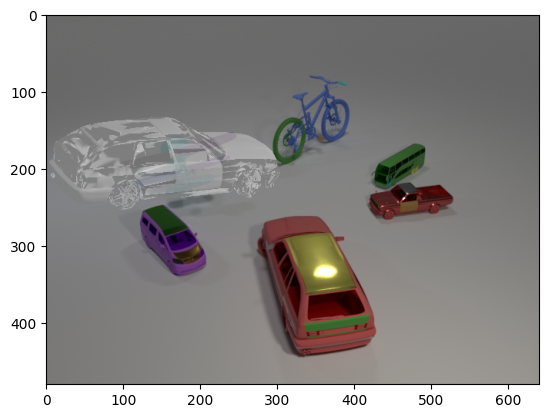

In [67]:
object_id = 1

image_id = '31811'
pred = nemo_pred[image_id]
img = cv2.imread(os.path.join(IMAGE_PATH, f"superCLEVR_new_{int(image_id):06d}.png"))
img = img[:, :, ::-1]

azimuth = get_azimuth(pred[object_id]['azimuth']/np.pi*180)
print(azimuth, pred[object_id]['azimuth'])
output, segmentation_mask, depth = plot_mesh_obj(img, mesh_path, pred[object_id]['azimuth'],pred[object_id]['elevation'], \
          pred[object_id]['theta'],pred[object_id]['distance'],pred[object_id]['principal'])

# output[segmentation_mask[:, :, 0], :] = 255
plt.imshow(output)


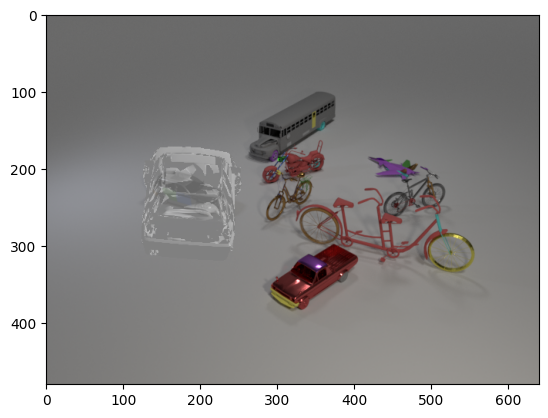

In [43]:
object_id = 1

image_id = '31810'
pred = nemo_pred[image_id]
img = cv2.imread(os.path.join(IMAGE_PATH, f"superCLEVR_new_{int(image_id):06d}.png"))
img = img[:, :, ::-1]

output, segmentation_mask, depth = plot_mesh_obj(img, mesh_path,0,pred[object_id]['elevation'], \
          pred[object_id]['theta'],pred[object_id]['distance'],pred[object_id]['principal'])

# output[segmentation_mask[:, :, 0], :] = 255
plt.imshow(output)


In [ ]:
def get_visible_numpy(part_name, all_images):

    part_visible = (all_images['obj'] >= 0) * (all_images['obj'] == all_images[part_name])
    return part_visible


object_id = 4

# azimuth = pred[object_id]['azimuth'] / np.pi * 180
# print(azimuth)
# azimuth =  (360 - 90 - azimuth) / 180 * np.pi
azimuth = (np.pi/3 - pred[object_id]['azimuth']) % (2 * np.pi)
# print(pred[object_id]['azimuth'], azimuth)

azimuth = (pred[object_id]['azimuth']) % (np.pi*2)
print(pred[object_id]['azimuth'], azimuth)
# azimuth = 90
# azimuth = (60 - azimuth) % 360 / 180 * np.pi
# print(pred[object_id]['distance'])
# all_images_car = get_single_object_mesh('biplane',pred[object_id]['azimuth'],pred[object_id]['elevation'], \
#           pred[object_id]['theta'],pred[object_id]['distance']+3,pred[object_id]['principal'])
all_images_car = get_single_object_mesh('wagon',azimuth,pred[object_id]['elevation'], \
          pred[object_id]['theta'],pred[object_id]['distance']+3,pred[object_id]['principal'])
print(all_images_car.keys())
plt.imshow(get_visible_numpy('obj', all_images_car))
plt.imshow(img)
plt.show()
plt.imshow(all_images_car['obj'])
plt.show()

# object_id = 2
# all_images_motor = get_single_object_mesh('double',pred[object_id]['azimuth'],pred[object_id]['elevation'], \
#           pred[object_id]['theta'],pred[object_id]['distance'],pred[object_id]['principal'])
# # print(all_images.keys())
# plt.imshow(all_images_motor['obj'])
# plt.show()
# scene = np.minimum(all_images_motor['obj'], all_images_car['obj'])
# plt.imshow(all_images_motor['obj']-scene*(scene>0))
# plt.show()

1.363908052444458 1.363908052444458


NameError: name 'get_single_object_mesh' is not defined

In [ ]:
mask = np.where(all_images_car['obj']>0, -50, 0)[:, :, None][:, :, None]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


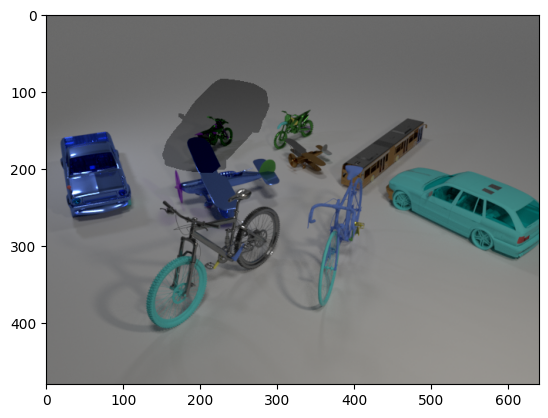

In [ ]:
plt.imshow(mask+img)

In [ ]:
this_anno = json.load(open('/home/xingrui/vqa/super-clevr-gen/output/ver_mask_new/scenes/superCLEVR_new_025310.json'))

In [ ]:
this_anno['objects']

[{'color': 'green',
  'size': 'small',
  'rotation': 18.267543048738702,
  '3d_coords': [-2.9772515296936035,
   -0.05836325138807297,
   0.33780065178871155],
  'texture': None,
  'material': 'metal',
  'shape': 'dirtbike',
  'pixel_coords': [[213, 166, 13.03762149810791], [640, 480]],
  'parts': {'fork': {'color': 'purple', 'material': 'rubber', 'size': 'small'},
   'gas_tank': {'color': 'purple', 'material': 'rubber', 'size': 'small'},
   'cover_back': {'color': 'purple', 'material': 'rubber', 'size': 'small'}}},
 {'color': 'blue',
  'size': 'large',
  'rotation': 161.49823140536887,
  '3d_coords': [-0.8359817266464233, -1.1020270586013794, 0.5312719345092773],
  'texture': None,
  'material': 'metal',
  'shape': 'biplane',
  'pixel_coords': [[232, 213, 10.936820030212402], [640, 480]],
  'parts': {'fin': {'color': 'green', 'material': 'rubber', 'size': 'large'},
   'propeller': {'color': 'purple', 'material': 'rubber', 'size': 'large'},
   'wheel_front': {'color': 'purple', 'materi

remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []
remove []


In [ ]:

# part_name_match
# obj_info['info_part_labels']['tandem']
# with open("name_match.json","w") as f:
#     json.dump(part_name_match, f)

In [ ]:
import os
import json
# pred = json.load(open('/home/xingrui/vqa/nemo_superclevr_copy/output/json/0424_15000/anno_prob_part_test.json')
pred = json.load(open('/home/xingrui/vqa/FaseRCNN3d_PNSVQA/data/fastRCNN3D/reason/scene_pred-fastrcnn3d.json'))
pred.keys()


dict_keys(['31810', '31811', '31812', '31813', '31814', '31815', '31816', '31817', '31818', '31819', '31820', '31821', '31822', '31823', '31824', '31825', '31826', '31827', '31828', '31829', '31830', '31831', '31832', '31833', '31834', '31835', '31836', '31837', '31838', '31839', '31840', '31841', '31842', '31843', '31844', '31845', '31846', '31847', '31848', '31849', '31850', '31851', '31852', '31853', '31854', '31855', '31856', '31857', '31858', '31859', '31860', '31861', '31862', '31863', '31864', '31865', '31866', '31867', '31868', '31869', '31870', '31871', '31872', '31873', '31874', '31875', '31876', '31877', '31878', '31879', '31880', '31881', '31882', '31883', '31884', '31885', '31886', '31887', '31888', '31889', '31890', '31891', '31892', '31893', '31894', '31895', '31896', '31897', '31898', '31899', '31900', '31901', '31902', '31903', '31904', '31905', '31906', '31907', '31908', '31909', '31910', '31911', '31912', '31913', '31914', '31915', '31916', '31917', '31918', '31919',

In [ ]:
import cv2
# pred['31810']
img = cv2.imread(os.path.join(IMAGE_PATH,pred['31810'][0]['image_filename']))[:, :, ::-1]


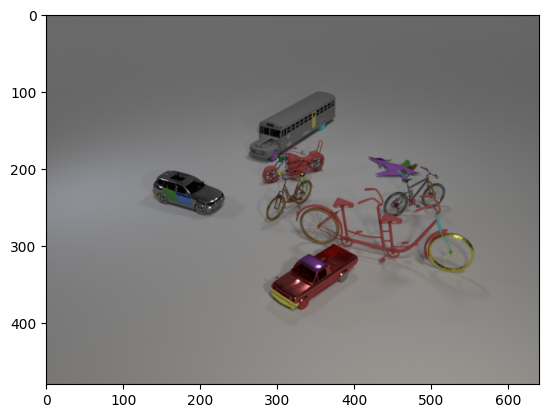

In [ ]:

plt.imshow(img)

In [ ]:
# pred['31810'][1]['parts']

In [ ]:

bbox = pred['31809'][1]['_parts']['roof']['bbox']
new_img = img[:, :, :]
new_img[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2], ] = 255

plt.imshow(new_img)

# for part, dect in pred['31809'][0]['parts'].items():
#     bbox = dect['bbox']
#     img[bbox[0]:bbox[0]+bbox[2], bbox[1]:bbox[1]+bbox[3]]

#     plt.imshow(img[bbox[0]:bbox[0]+bbox[2], bbox[1]:bbox[1]+bbox[3]])
    

KeyError: '31809'

# Test attr prediction

In [ ]:
import json
# pred = json.load(open('/home/xingrui/vqa/FaseRCNN3d_PNSVQA/data/fastRCNN3D/reason/scene_pred-fastrcnn3d.json'))
pred = json.load(open('/home/xingrui/vqa/FaseRCNN3d_PNSVQA/faster_rcnn_6d/fastrcnn_detection.json'))


In [ ]:
import numpy as np
SUPERCLEVR_COLORS =  ['gray', 'red', 'blue', 'green', 'brown', 'purple', 'cyan', 'yellow']
SUPERCLEVR_MATERIALS = ['rubber', 'metal']
SUPERCLEVR_SHAPES = ['car', 'suv', 'wagon', 'minivan', 'sedan', 'truck', 'addi', 'bus', 'articulated', 'regular', 'double', 'school', 'motorbike', 'chopper', 'dirtbike', 'scooter', 'cruiser', 'aeroplane', 'jet', 'fighter', 'biplane', 'airliner', 'bicycle', 'road', 'utility', 'mountain', 'tandem']
SUPERCLEVR_PARTNAMES = ['left_mirror', 'fender_front', 'footrest', 'wheel_front_right', 'crank_arm_left', 'wheel_front_left', 'bumper', 'headlight', 'door_front_left', 'wing', 'front_left_wheel', 'side_stand', 'footrest_left_s', 'tailplane_left', 'wheel_front', 'mirror', 'right_head_light', 'back_left_door', 'left_tail_light', 'head_light_right', 'gas_tank', 'front_bumper', 'tailplane', 'taillight_center', 'back_bumper', 'headlight_right', 'panel', 'front_right_door', 'door_mid_left', 'hood', 'door_left_s', 'front_right_wheel', 'wing_left', 'head_light_left', 'back_right_door', 'tail_light_right', 'seat', 'taillight', 'door_front_right', 'trunk', 'back_left_wheel', 'exhaust_right_s', 'cover', 'brake_system', 'wing_right', 'pedal_left', 'rearlight', 'headlight_left', 'right_tail_light', 'engine_left', 'crank_arm', 'fender_back', 'engine', 'fender', 'door_back_right', 'wheel_back_left', 'back_license_plate', 'cover_front', 'headlight_center', 'engine_right', 'roof', 'left_head_light', 'taillight_right', 'fin', 'saddle', 'mirror_right', 'door', 'bumper_front', 'door_mid_right', 'head_light', 'bumper_back', 'wheel_back_right', 'footrest_right_s', 'drive_chain', 'license_plate_back', 'tail_light', 'pedal', 'windscreen', 'license_plate', 'exhaust_left_s', 'handle_left', 'handle', 'back_right_wheel', 'right_mirror', 'wheel', 'fork', 'taillight_left', 'handle_right', 'front_left_door', 'carrier', 'license_plate_front', 'crank_arm_right', 'wheel_back', 'cover_back', 'propeller', 'exhaust', 'tail_light_left', 'mirror_left', 'pedal_right', 'tailplane_right', 'door_right_s', 'front_license_plate']
SUPERCLEVR_SIZES = ['large', 'small']


scene_id = '31810'
for obj in pred[scene_id]:
    # shape_id = np.argmax(obj['shape'])
    # print(SUPERCLEVR_SHAPES[shape_id],  obj['bbox'])
    print(obj['boxes'])


In [ ]:
pred_1 = json.load(open('/home/xingrui/vqa/FaseRCNN3d_PNSVQA/faster_rcnn_6d/fastrcnn_detection.json'))


In [ ]:
pred_1[scene_id]

In [ ]:
import numpy as np

def rotation_matrix_x(angle_radians):
    return np.array([[1, 0, 0],
                     [0, np.cos(angle_radians), -np.sin(angle_radians)],
                     [0, np.sin(angle_radians),  np.cos(angle_radians)]])

def rotation_matrix_y(angle_radians):
    return np.array([[np.cos(angle_radians),  0, np.sin(angle_radians)],
                     [0, 1, 0],
                     [-np.sin(angle_radians), 0, np.cos(angle_radians)]])

def rotation_matrix_z(angle_radians):
    return np.array([[np.cos(angle_radians), -np.sin(angle_radians), 0],
                     [np.sin(angle_radians),  np.cos(angle_radians), 0],
                     [0,                      0,                     1]])

location = np.array([7.48113, -6.50764, 5.34367])

location = np.array([7.433665752410889, -6.414364337921143, 5.5400800704956055])
rotation = np.array([1.10932, 0.0, 0.814928])  # Euler angles in radians
R_x = rotation_matrix_x(rotation[0])
R_y = rotation_matrix_y(rotation[1])
R_z = rotation_matrix_z(rotation[2])

R = R_z.dot(R_y).dot(R_x)
camera_matrix = np.eye(4)
camera_matrix[:3, :3] = R
camera_matrix[:3, 3] = location

camera_matrix_inverse = np.linalg.inv(camera_matrix)


In [ ]:
camera_matrix_inverse = np.linalg.inv(np.array([[0.6425608396530151, -0.39441466331481934, 0.6569265723228455, 7.388879299163818], [0.7662346363067627, 0.3307543098926544, -0.550895631313324, -6.196280479431152], [1.4901161193847656e-08, 0.8573439121246338, 0.514743983745575, 5.78965950012207], [0.0, 0.0, 0.0, 1.0]]))

In [ ]:
# Replace x, y, and z with the object's coordinates
import math
x, y, z = [1, 0, 0]
object_position = np.array([x, y, z, 1])

# Since the rotation of the object on the Z-axis is 0, no rotation is applied
rotation_angle_degrees = 151.27125843494554,
# rotation_angle_degrees = 0.5
# object_position_rotated = object_position[:3]
R_obj_z = rotation_matrix_z(np.radians(rotation_angle_degrees))
object_position_rotated = R_obj_z.dot(object_position[:3])
# Transform the rotated object's position to homogeneous coordinates
object_position_homogeneous = np.append(object_position_rotated, 1)
print(object_position_rotated)
# Transform the object's position to camera space
camera_space_position = camera_matrix_inverse.dot(object_position_homogeneous)

# Compute the azimuth angle in camera space
azimuth_angle_radians = math.atan2(camera_space_position[1], camera_space_position[0])

# Convert the azimuth angle to degrees
azimuth_angle_degrees = np.degrees(azimuth_angle_radians)
azimuth_angle_degrees

[array([-0.87690516]) array([0.48066344]) 0]


/tmp/ipykernel_27293/210639259.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([[np.cos(angle_radians), -np.sin(angle_radians), 0],


111.13557399842814

In [30]:
# Replace x, y, and z with the object's coordinates
import math
import numpy as np


def get_azimuth(rotation_angle_degrees, camera_matrix = np.array([[0.6425608396530151, -0.39441466331481934, 0.6569265723228455, 7.388879299163818], [0.7662346363067627, 0.3307543098926544, -0.550895631313324, -6.196280479431152], [1.4901161193847656e-08, 0.8573439121246338, 0.514743983745575, 5.78965950012207], [0.0, 0.0, 0.0, 1.0]])):
    def rotation_matrix_z(angle_radians):
        return np.array([[np.cos(angle_radians), -np.sin(angle_radians), 0],
                        [np.sin(angle_radians),  np.cos(angle_radians), 0],
                        [0,                      0,                     1]])
    rotation_angle_degrees = 151.27125843494554
    camera_matrix_inverse = np.linalg.inv(camera_matrix)
    x, y, z = [1, 0, 0]
    object_position = np.array([x, y, z, 1])

    # rotation_angle_degrees = 0.5
    # object_position_rotated = object_position[:3]
    R_obj_z = rotation_matrix_z(np.radians(rotation_angle_degrees))
    object_position_rotated = R_obj_z.dot(object_position[:3])
    # Transform the rotated object's position to homogeneous coordinates
    object_position_homogeneous = np.append(object_position_rotated, 1)
    # Transform the object's position to camera space
    camera_space_position = camera_matrix_inverse.dot(object_position_homogeneous)

    # Compute the azimuth angle in camera space
    azimuth_angle_radians = math.atan2(camera_space_position[1], camera_space_position[0])

    # Convert the azimuth angle to degrees
    # azimuth_angle_degrees = np.degrees(azimuth_angle_radians) / 180 * np.pi
    return -azimuth_angle_radians

In [14]:
get_azimuth(151.27125843494554, np.array([[0.6425608396530151, -0.39441466331481934, 0.6569265723228455, 7.388879299163818], [0.7662346363067627, 0.3307543098926544, -0.550895631313324, -6.196280479431152], [1.4901161193847656e-08, 0.8573439121246338, 0.514743983745575, 5.78965950012207], [0.0, 0.0, 0.0, 1.0]]))

-1.9396816823663705